### Import data

In [1]:
include("importData.jl")
include("Hill.jl")
include("plot.jl")

# import drug concentrations
param_lap_dde = CSV.read(".//figures//Dox//params_dox_DDE.csv")
concentrations = permutedims(Vector(param_lap_dde[8,2:end]));
print(concentrations)

# import G1 and G2 data
pop, g2, g1, g2_0, g1_0 = get_data("..//data//dox.csv", "..//data//dox_pop.csv");

Any[0.0 1.0 10.0 20.0 50.0 125.0 250.0 500.0]

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:29
└ @ Main /home/farnazm/Hill/one_state_model/model/importData.jl:29


### Hill model, residual functions and optimization

In [2]:
# lower bound
low = [50.0, 0.001, 0.2, 0.01, 0.01, 0.001, 0.01, 20.0, 0.1, 0.01, 19.0, 0.01, 0.01, 0.001, 0.01, 0.001, 0.01]
# upper bound
high = [250.0, 0.01, 0.4, 0.04, 0.05, 0.02, 0.04, 35.0, 3.0, 0.04, 23.0, 2.0, 0.4, 0.01, 0.04, 0.04, 0.04]
# initial guess
guess = [100.0, 0.005, 0.3, 0.02, 0.02, 0.006, 0.02, 25.0, 1.2, 0.02, 20.0, 0.2, 0.02, 0.001, 0.02, 0.01, 0.02]

optimizer_result = optimize_hill(concentrations, guess, low, high)

Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [50.0,0.01,0.2,0.01,0.02139840097716305,0.02,0.010150627438258055,20.02861065464572,0.1100381611371733,0.01256259168202457,21.251900851010852,0.02437423798918505,0.08253239735569748,0.01,0.018578150632589562,0.04,0.010262664025413355]
 * Sum of squares at Minimum: 130788.438703
 * Iterations: 45
 * Convergence: true
 * |x - x'| < 1.0e-08: true
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: false
 * |g(x)| < 1.0e-08: false
 * Function Calls: 46
 * Gradient Calls: 26
 * Multiplication Calls: 135


### Plot Hill curve for all of the DDE model parameters

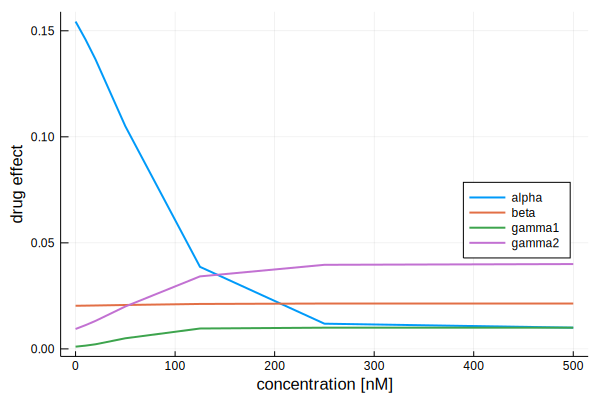

In [3]:
using Plots;
params = optimizer_result.minimizer
effects = zeros(6, 8)
for i in 1:8
    effects[1, i] = hill(params[1:4], concentrations[i])
    effects[2, i] = hill(append!([params[1]], params[5:7]), concentrations[i])
    effects[3, i] = hill(append!([params[1]], params[8:10]), concentrations[i])
    effects[4, i] = hill(append!([params[1]], params[11:13]), concentrations[i])
    effects[5, i] = hill(append!([params[1], params[14]], [0, params[15]]), concentrations[i])
    effects[6, i] = hill(append!([params[1], params[16]], [0, params[17]]), concentrations[i])
end


c = permutedims(Array(concentrations))
plot(c, effects[1, :], label = "alpha", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(c, effects[2, :], label = "beta", linewidth = 2, legend =:right)
plot!(c, effects[5, :], label = "gamma1", linewidth = 2)
plot!(c, effects[6, :], label = "gamma2", linewidth = 2)


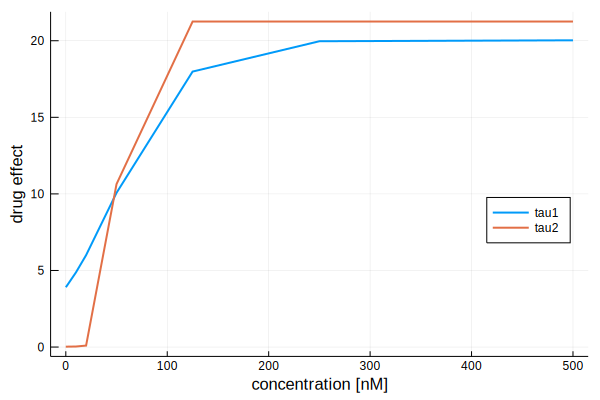

In [4]:
plot(c, effects[3, :], label = "tau1", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(c, effects[4, :], label = "tau2", linewidth = 2, legend =:right)

### Plot the data with the new set of parameters for DDE

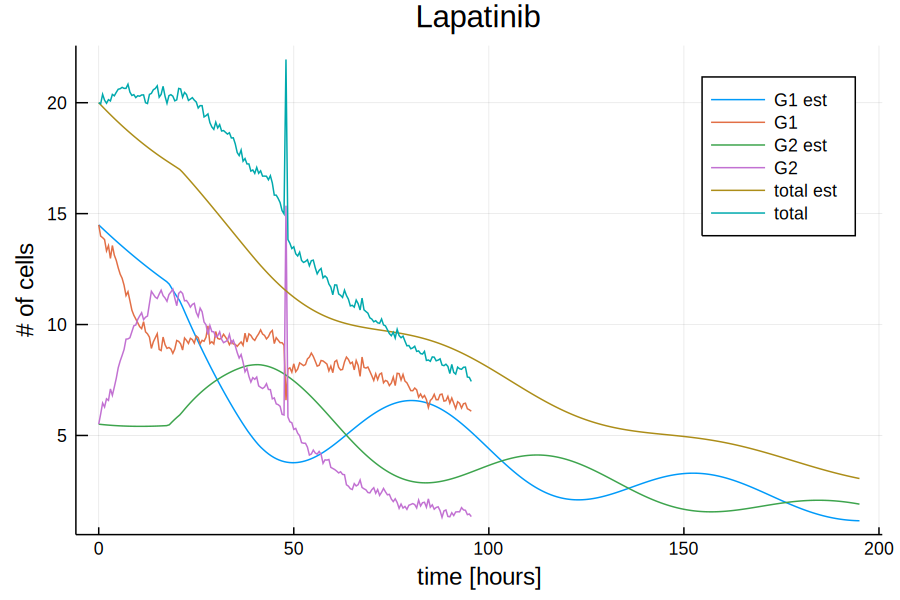

In [12]:
j = 6 # trial number
# for instance we want to plot the data and estimated for some trial 
alpha_ = hill(params[1:4], concentrations[j])
beta_ = hill(append!([params[1]], params[5:7]), concentrations[j])
tau1_ = hill(append!([params[1]], params[8:10]), concentrations[j])
tau2_ =hill(append!([params[1]], params[11:13]), concentrations[j])
gamma1_ = hill(append!([params[1], params[14]], [0, params[15]]), concentrations[j])
gamma2_ = hill(append!([params[1], params[16]], [0, params[17]]), concentrations[j])

dde_params = [alpha_, beta_, tau1_, tau2_, gamma1_, gamma2_]
plotIt(dde_params, g1, g2, g1_0, g2_0, pop, j, "Lapatinib")
